In [82]:
import pandas as pd
import re
import gensim
import matplotlib
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import numpy as np
import warnings
import joblib

from matplotlib import pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models

In [60]:
warnings.filterwarnings('ignore') # 경고창 무시

## 특수문자 제거 함수

In [61]:
def remove_html_tags(text):
    clean_text = re.sub(r'<.*?>|[^\w\s]', '', text)
    return clean_text

In [62]:
df = pd.read_csv('MRAM-semiconductor.csv', encoding='cp949')

In [63]:
df['title_abstract'] = df['patent_title'] + df['patent_abstract'] # title + abstract
df['clean_text'] = df['title_abstract'].apply(lambda x: remove_html_tags(str(x))) # 특수문자 제거

In [64]:
tokenizer = RegexpTokenizer('[\\w]+') # 텍스트를 단어 단위를 토큰화
stop_words = stopwords.words('english') # stopwords 영어 키워드 저장 -> 라이브러리에서 기본적으로 제공
lemmatizer = WordNetLemmatizer() # 표제어 

## 특수문자 제거된 데이터를 df_text 리스트안에 저장

In [65]:
df_text = []

for idx, st in enumerate(df['clean_text']):
    try:
        df_text.append(st.lower())
    except AttributeError as e:
       continue

## 사용자 지정 불용어

In [76]:
user_stopwords = ['the', 'and', 'for', 'first','layer', 'method', 'second', 'line', 'lines',
                  'with', 'via', 'memory', 'device', 'over', 'having', 'forming', 'magnetic', 
                  'top', 'each', 'with', 'forms', 'includes', 'cell', 'that', 'disposed',
                  'are', 'which', 'formed', 'random', 'bit', 'access', 'from', 'may', 'word',
                  'least', 'devices', 'region', 'array', 'structure', 'cells', 'contact', 'between', 
                  'substrate', 'layers', 'mtj', 'portion', 'junction', 'conductive', 'tunnel',
                  'metal', 'free', 'semiconductor', 'mram', 'can', 'including', 'one', 'writing',
                  'electrode']

In [77]:
text = []
sentence = []

for w in df_text:

    tokens = tokenizer.tokenize(w) # abstract + title이 담긴 텍스트 데이터를 토큰화
    
    stopped_tokens = [i for i in tokens if not i in stop_words] # 1차로 기본 라이브러리에서 제공하는 불용어로 필터링
    stemmed_tokens = [lemmatizer.lemmatize(i, pos='n') for i in stopped_tokens] # 명사(Noun) 형태로 키워드의 기본형을 추출하여 저장
    stemmed_tokens = [i for i in tokens if (not i in user_stopwords)] # 2차로 사용자 지정 불용어로 필터링
    stemmed_tokens = [i for i in stemmed_tokens if len(i) > 2] # 키워드가 2개 초과(3개이상) 인것만 추출
    text.append(stemmed_tokens) # text 리스트안에 저장
    
dictionary = corpora.Dictionary(text) # text 리스트를 사전형(Dictionary)으로 변경

corpus = [dictionary.doc2bow(t) for t in text] # 문서를 Bag of Words 형식으로 변환하여 말뭉치(corpus)를 생성함

## Coherence score : 최적의 토픽 개수 설정 

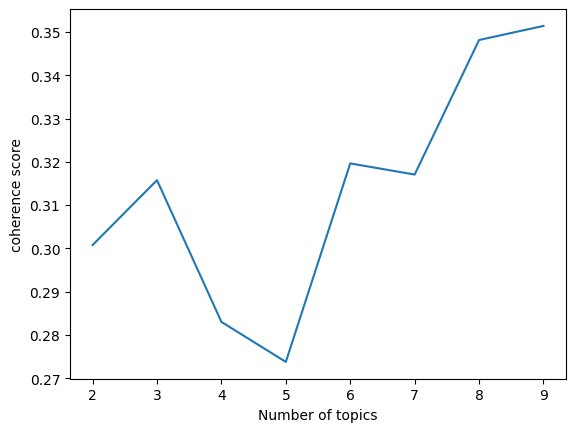

In [78]:
coherence_values = []
for i in range(2, 10):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word=dictionary)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts = text, dictionary=dictionary, topn=10)
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

x = range(2, 10)
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.show()

## LDA 모델 구축

In [79]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=6, id2word = dictionary, random_state=3)

In [83]:
# 모델 저장
# joblib.dump(ldamodel, 'ldamodel_saved.joblib')

['ldamodel_saved.joblib']

In [84]:
# 모델 불러오기
# loaded_model = joblib.load('ldamodel_saved.joblib')

## 각 토픽별 10개의 키워드를 출력

In [85]:
ldamodel.print_topics(num_words=10)

[(0,
  '0.012*"insulating" + 0.011*"element" + 0.011*"material" + 0.011*"bottom" + 0.010*"dielectric" + 0.009*"barrier" + 0.007*"area" + 0.007*"ferromagnetic" + 0.007*"surface" + 0.006*"manufacturing"'),
 (1,
  '0.020*"dielectric" + 0.014*"magnetoresistive" + 0.013*"surface" + 0.011*"stop" + 0.009*"upper" + 0.009*"electrical" + 0.009*"bottom" + 0.008*"etch" + 0.008*"insulating" + 0.008*"source"'),
 (2,
  '0.011*"magnetoresistive" + 0.010*"structures" + 0.010*"data" + 0.009*"dielectric" + 0.009*"chip" + 0.009*"alignment" + 0.008*"different" + 0.008*"material" + 0.008*"shield" + 0.008*"storage"'),
 (3,
  '0.019*"material" + 0.014*"stack" + 0.014*"magnetoresistive" + 0.012*"spacer" + 0.009*"form" + 0.009*"reference" + 0.008*"upper" + 0.008*"sidewall" + 0.007*"coupled" + 0.007*"transistor"'),
 (4,
  '0.012*"voltage" + 0.012*"current" + 0.010*"area" + 0.010*"circuit" + 0.010*"plurality" + 0.008*"integrated" + 0.008*"material" + 0.006*"structures" + 0.006*"process" + 0.006*"bottom"'),
 (5,
 

## 구축된 모델을 기반으로 LDA를 시각화

In [81]:
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)